In [244]:
import qutip as qt
import numpy as np
import os, sys
import expm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [245]:
from lfig import LatexFigure

sys.path.append("/home/bf16951/QMD")
import qmla

%matplotlib inline


In [246]:
zero = np.array([1,0])
one = np.array([0,1])

paulis = {
    'y' : np.array([
        [0,-1j], 
        [1j, 0]
    ]),
    'z' : np.array([
        [1,0], [0,-1]
    ]),
    'x' : np.array([
        [0,1], [1,0]
    ])

}

In [308]:
hamiltonian_terms = {
#     'pauliSet_1_x_d1' : 0.25, 
    'pauliSet_1_y_d1' : 0.25,
#     'pauliSet_1_z_d1' : 0.25
}

ham_components = [qmla.construct_models.compute(t)*hamiltonian_terms[t] for t in hamiltonian_terms]
hamiltonian = np.sum(
    ham_components,
    axis=0
)
    
# hamiltonian = np.eye(2)

t = 0.5 # microsecond

In [309]:
def progress_state(
    hamiltonian, 
    t, 
    second_time_ev_factor = 2
):
    initial_state = zero

    # Prepare in |+>
    pi_by_2_gate = expm.expm(
        -1j*(np.pi/4) * paulis['y']
    )
    prepared_state = np.dot(
        pi_by_2_gate, initial_state
    )

    # first_evolution

    u = expm.expm(-1j*hamiltonian*t)

    evolved_state = np.dot(u, prepared_state)

    # Hahn gate
    hahn_gate = expm.expm(
        -1j*(np.pi/2) * paulis['y']
    )
    post_hahn_gate = np.dot(hahn_gate, evolved_state)

    # second evolution
    u2 = expm.expm(-1j*hamiltonian* second_time_ev_factor * t)
    second_evolved = np.dot(
        u2, 
        post_hahn_gate
    )

    # final pi/2 gate
    final_state = np.dot(
        pi_by_2_gate, second_evolved
    )
    state_progression =  [
        initial_state, 
        prepared_state,
        evolved_state, 
        post_hahn_gate, 
        second_evolved, 
        final_state
    ]
    return state_progression

In [310]:
all_states = {}
times_to_study = list(np.arange(0, 10, 0.25))
for t in times_to_study:
    all_states[t] = progress_state(
        hamiltonian = hamiltonian,
        t=t
    )

In [311]:
full_state_progression = all_states[times_to_study[2]]
qt_states = [
    qt.Qobj(s) for s in full_state_progression
]
state_colours = [
    'g', 'b', 'k', 'b', 'k', 'r'
]

descriptions = [
    r"$| \psi_0 \rangle = | 0 \rangle$",
    r"$| \psi_1 \rangle = e^{-i \frac{\pi}{2} \hat{\sigma}_y} | \psi_0 \rangle$",
    r"$| \psi_2 \rangle = e^{-i \hat{H}_0 t} | \psi_1 \rangle$",
    r"$| \psi_3 \rangle = e^{-i \pi \hat{\sigma}_y} | \psi_2 \rangle$",
    r"$| \psi_4 \rangle = e^{-2i \hat{H}_0 t} | \psi_3 \rangle$",
    r"$| \psi_5 \rangle = e^{-i \frac{\pi}{2} \hat{\sigma}_y} | \psi_4 \rangle$",
]


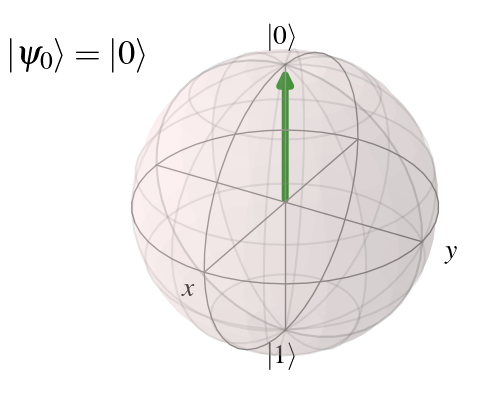

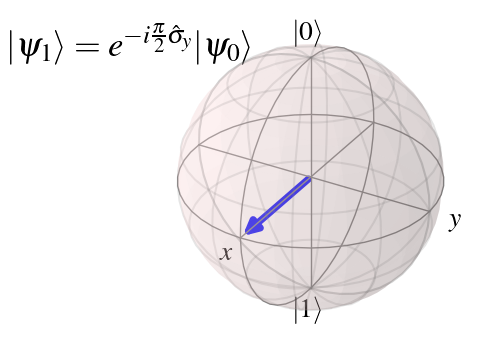

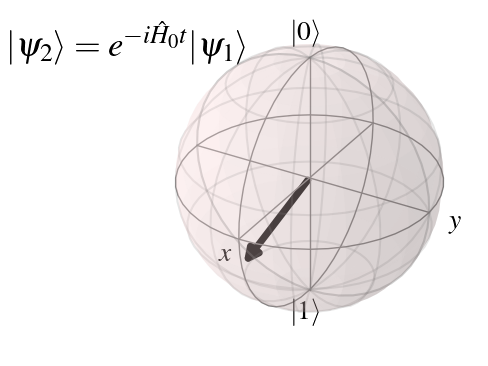

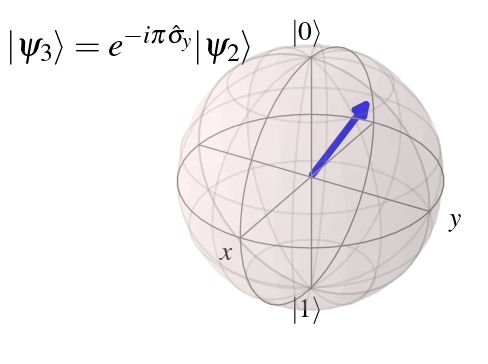

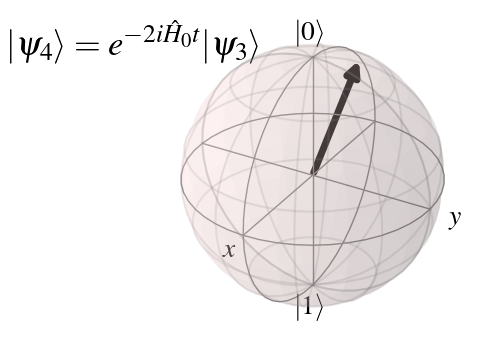

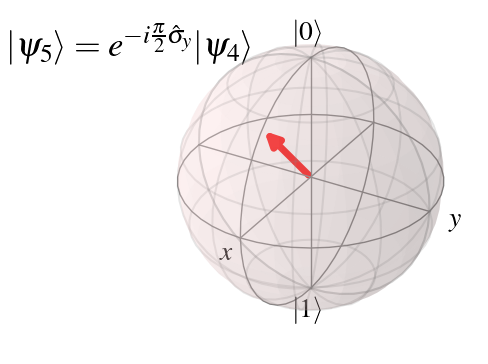

In [312]:
for s, c in list(zip(qt_states, state_colours)):
    fig, ax = plt.subplots(
        figsize=(5, 5), 
        subplot_kw=dict(projection='3d')
    )
    ax.axis('square') # to get a nice circular plot

    
    bloch = qt.Bloch(
        fig = fig, 
        axes = ax
    )
    bloch.vector_color = c
    bloch.vector_width = 5
    bloch.add_states(s)

    
#     bloch.zlabel = ['z', '']
    bloch.render(fig=fig, axes=ax) # render to the correct subplot 

    idx = qt_states.index(s)
#     ax.set_title("{}".format(idx))
    ax.annotate(
        descriptions[idx], 
        xy=(0.0, 0.9), 
        xytext=(0, 0.85), 
        xycoords='axes fraction',
        fontsize=25, 
        color='black', 
        ha='center',
    )
    save_path = os.path.join(
        "/home/bf16951/thesis/experimental_study/figures/hahn_bloch_spheres",
        "bloch_{}.pdf".format(idx)
    )
#     plt.show()
    plt.tight_layout()
    fig.savefig(save_path, tight_layout=True)


In [316]:
np.abs(np.dot(full_state_progression[-1], full_state_progression[0]))**2

0.8658444344369104

In [314]:
full_state_progression

[array([1, 0]),
 array([0.70710678+0.j, 0.70710678+0.j]),
 array([0.61343135+0.j, 0.78974805+0.j]),
 array([-0.78974805+0.j,  0.61343135+0.j]),
 array([-0.91696204+0.j,  0.39897446+0.j]),
 array([-0.93050762+0.j, -0.36627253+0.j])]

In [315]:
times_to_study[2]

0.5

In [9]:
# Hahn probes study

In [12]:
from expm import expm

-0.11515009415955535

In [23]:
def random_initialised_qubit_for_hahn_sequence(
    hahn_rotation = None
):
    pauli_y = np.array([
        [0,-1j], 
        [1j, 0]
    ])
    spin_qubit = np.array([1,0]) # prepared in |0>
    if hahn_rotation is None: 
        hahn_rotation = np.random.rand()
    hahn_angle = hahn_rotation*(np.pi/2)

    hahn_gate = expm(
        -1j * hahn_angle * pauli_y
    )

    spin_qubit = np.dot(hahn_gate, spin_qubit)
    return spin_qubit

def hahn_sequence_random_initial(
    max_num_qubits=2,
    num_probes=40,
    noise_level=0.03,  
    **kwargs
):

    separable_probes = {}
    for i in range(num_probes):
        rand_init_state = random_initialised_qubit_for_hahn_sequence()
        separable_probes[i, 0] = rand_init_state
        for j in range(1, 1 + max_num_qubits):
            if j == 1:
                separable_probes[i, j] = separable_probes[i, 0]
            else:
                
                separable_probes[i, j] = (
                    np.tensordot(
                        separable_probes[i, j - 1],
                        rand_init_state,
                        axes=0
                    ).flatten(order='c')
                )
            while (
                np.isclose(
                    1.0,
                    np.linalg.norm(separable_probes[i, j]),
                    atol=1e-14
                ) is False
            ):
                print("non-unit norm: ",
                      np.linalg.norm(separable_probes[i, j])
                      )
                # keep replacing until a unit-norm
                separable_probes[i, j] = (
                    np.tensordot(
                        separable_probes[i, j - 1],
                        rand_init_state,
                        axes=0
                    ).flatten(order='c')
                )
    return separable_probes




In [33]:
probes = hahn_sequence_random_initial()

In [35]:
probes[(10,0)]

array([0.99573302+0.j, 0.09228087+0.j])

In [37]:
two_q = probes[(10,2)]

In [47]:
b = np.tensordot(
    probes[(10,1)], probes[(10,1)], axes=0
).flatten(order='c')